# Dados de desmatamento do Prodes

Fonte: <http://www.dpi.inpe.br/prodesdigital/prodesmunicipal.php>

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np

import prodes as pr
import utils as xu
import correlation as xc

## Funções

In [2]:
def compute_measured_area_frac(df):
    
    return (df['Desmatado'] + df['Floresta'] + df['Nuvem'] + df['NaoObservado'] + df['NaoFloresta'] + df['Hidrografia']) / df['AreaKm2'] * 100

In [3]:
def avg_desmatamento_in_period(df, min_year, max_year, avg_cols=['AreaKm2', 'Desmatavel', 'Incremento', 'frac_desmatavel', 'frac_area']):
    """
    Return the average of columns `avg_cols` 
    (list of str) from DataFrame `df` in 
    the year range `min_year` (int) to 
    `max_year` (int, inclusive).
    
    It returns a DataFrame.
    """
    years = list(range(min_year, max_year + 1))
    sel = df.loc[df['Ano'].isin(years)]
    
    return sel.groupby('CodIbge')[avg_cols].mean()

In [4]:
def compare_deflorestation_voting_data(deflorestation, votos, cand, ctrl_yr_range=(2010, 2018), test_yr_range=(2019, 2020), increment_norm='desmatavel', km2_min=0.101):
    """
    Return a DataFrame with, for each municipality:
    - the fraction of votes obtained by the `cand` (str)
      candidate;
    - the difference between deflorestation rates in
      different periods;
    - other related columns.
    
    Input
    -----
    
    deflorestation : DataFrame
        Data about deflorestation per year and per 
        municipality. It must contain the columns:
        - 'Desmatavel', a measure of municipality size (in km2)
          that just includes regions that are or were forest 
          at Prodes start;
        - 'Incremento', that year deflorestation area in km2;
        - 'frac_desmatavel', the fraction between 'Incremento'
          and 'Desmatavel';
        - 'frac_area', the fraction between 'Incremento' and 
          the full municipality area;
        - 'Cod_Ibge', the municipality code.
    
    votos : DataFrame
        Data about the 2018 presidential elections, with 
        the columns:
        - 'NM_URNA_CANDIDATO': the candidate's name;
        - 'id_mun_ibge': the municipality ID;
        - 'frac_votos_totais': the amount of votes 
          obtained by the candidates in each municipality, 
          divided by all votes (valid, abstention and 
          null);
        - 'frac_votos_nominais': the same as above, but
          divided by the number of valid votes.
        - Other columns about votes.
    
    cand : str
        The candidate for which to calculate the fraction of 
        votes in each municipality.
        
    ctrl_yr_range : tuple of ints
        Year range (inclusive) used to compute the control
        average deflorestation rate.
    
    test_yr_range : tuple of ints
        The same as above, but for the test rate.
        
    increment_norm : str
        Whether the difference between the test and 
        control deflorestation rates should be 
        computed using the `deflorestation` column 
        'frac_desmatavel' or 'frac_area'.
        
    km2_min : float
        Minimum 'Desmatavel' area (km2) for municipalities 
        to be included in the output. Note that Prodes 
        does not detect deflorestation areas smaller than 
        0.0625 km2.
    """
    
    assert increment_norm in ('desmatavel', 'area')

    # Select data for a candidate:
    frac_votos_cand = votos.loc[votos['NM_URNA_CANDIDATO'] == cand].set_index('id_mun_ibge')[['VOTOS', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_TOTAIS', 'frac_votos_totais', 'frac_votos_nominais']]

    # Compute average deflorestation rate:
    df_desmatavel = deflorestation.loc[deflorestation['Desmatavel'] > km2_min] # O mínimo que o Prodes identifica são áreas de 6,25 ha, o que dá 0.0625 km2.
    ctrl_desmate = avg_desmatamento_in_period(df_desmatavel, ctrl_yr_range[0], ctrl_yr_range[1])
    test_desmate = avg_desmatamento_in_period(df_desmatavel, test_yr_range[0], test_yr_range[1])
    # Join rates into a single DataFrame:
    compare_desmate = ctrl_desmate.join(test_desmate[['Incremento', 'frac_desmatavel', 'frac_area']], lsuffix='_ctrl', rsuffix='_test')

    # Compute the difference between previous and following rates:
    diff_col = 'frac_{}_diff'.format(increment_norm)
    compare_desmate[diff_col] = compare_desmate['frac_{}_test'.format(increment_norm)] - compare_desmate['frac_{}_ctrl'.format(increment_norm)]

    # Join voting data:
    desmatamento_votos = compare_desmate.join(frac_votos_cand, on='CodIbge', how='left')
    
    return desmatamento_votos

In [5]:
def corr_stats(desmatamento_votos, drop_deflorestation=0.0075, deflorestation_col='frac_desmatavel_diff', votes_norm='totais'):
    """
    Compute statistics about the correlation
    between fraction of votes and deflorestation
    rate.
    
    Input
    -----
    
    desmatamento_votos : DataFrame
        DataFrame created by `compare_deflorestation_voting_data`
        function.
        
    drop_deflorestation : float
        Maximum deflorestation rate included in the 
        correlation computation.
    
    deflorestation_col : str
        Which column from `desmatamento_votos` 
        to use as a measure of deflorestation
        rate.
    
    votes_norm : str
        'totais' or 'nominais', the kind of 
        recorded votes to use to normalize the 
        number of votes in each municipality.
        If 'nominais', ignore nulls and abstentions.
        If 'totais', include those in the normalization.
        
    Return:
    
    random_corrs : array of floats
        Correlations obtained from scrambled
        input data.
    
    actual_corr : float
        Correlation between the specified deflorestation 
        rate and vote fractions.
    
    pvalue : float
        The one-sided pvalue for `actual_corr`.
    """
    
    # Choose votes column:
    votes_col = 'frac_votos_{}'.format(votes_norm)
    
    # Remove outliers:
    clip_desmatamento = desmatamento_votos.loc[desmatamento_votos[deflorestation_col].abs() < drop_deflorestation]
    
    # Compute correlation between deflorastation and votes:
    actual_corr  = xc.compute_correlation(clip_desmatamento[votes_col], clip_desmatamento[deflorestation_col])
    # Estimate correlation uncertainty:
    random_corrs = xc.bootstrap_correlation(clip_desmatamento[votes_col], clip_desmatamento[deflorestation_col])
    pvalue = (random_corrs > actual_corr).sum() / len(random_corrs)
    
    return random_corrs, actual_corr, pvalue

## Carregando dados

**Notas**

* A soma de todas as áreas em diferentes categorias deve dar a área total do município `AreaKm2`.
* A coluna `Soma` fala a fração da soma acima em relação a área do estado.
* O incremento de um ano é igual a diferença entre o desmatado daquele ano e o desmatado do ano anterior: $I_{a} = D_{a} - D_{a - 1}$
* A menor área de município da base é de 64km2.
* As colunas `AreaKm2`, `NaoFloresta` e `Hidrografia` são fixas ao longo do tempo.

In [6]:
areas_col = ['Incremento', 'AreaKm2', 'Desmatado', 'Floresta', 'Nuvem', 'NaoObservado', 'NaoFloresta', 'Hidrografia', 'Desmatavel', 'Disponivel']

In [7]:
# Dados de votação por município:
votos = pd.read_csv('../dados/processed/fracao_votos_2018_por_candidato_municipio.csv')

In [8]:
df = pr.etl_prodes_data('../dados/brutos/desmatamento/prodes/prodes_DesmatamentoMunicipios', 2010, 2020)

## Explorando os dados

### Desmatamento no Brasil

In [9]:
agg_br = df.groupby('Ano')[areas_col].sum()

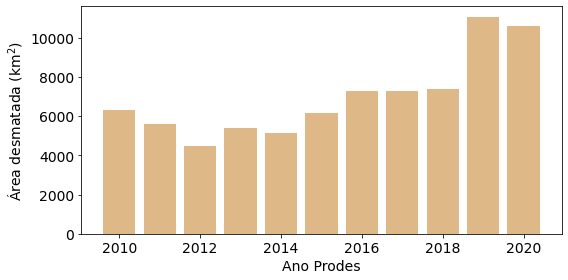

In [10]:
pl.figure(figsize=(8,4))
pl.bar(agg_br.index, agg_br['Incremento'], color='burlywood')
pl.tick_params(labelsize=14)
pl.xlabel('Ano Prodes', fontsize=14)
pl.ylabel('Área desmatada ($\mathrm{km^2}$)', fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/area_desmatada_por_ano_2010-2020.png')
pl.show()

In [11]:
abs_by_uf = df.loc[df['Ano'] == 2020].groupby('Estado')['Incremento'].sum().sort_values(ascending=False)
area_by_uf = df.loc[df['Ano'] == 2020].groupby('Estado')['Desmatavel'].sum()
frac_by_uf = (abs_by_uf / area_by_uf * 100).sort_values(ascending=False)

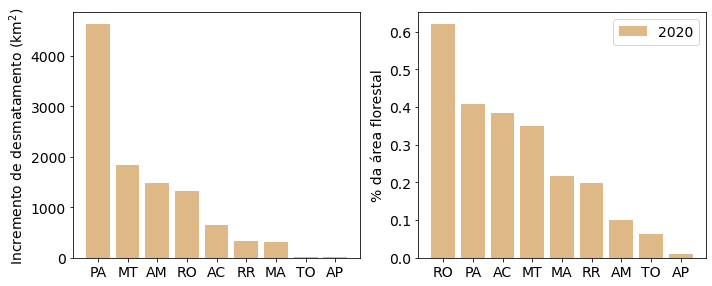

In [14]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.bar(abs_by_uf.index, abs_by_uf.values, color='burlywood')
pl.tick_params(labelsize=14)
pl.ylabel('Incremento de desmatamento ($\mathrm{km^2})$', fontsize=14)

pl.subplot(1,2,2)
pl.bar(frac_by_uf.index, frac_by_uf.values, color='burlywood', label=2020)
pl.tick_params(labelsize=14)
pl.ylabel('% da área florestal', fontsize=14)
pl.legend(fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/desmatamento_prodes_2020_por_UF.png')
pl.show()

### Relação entre votos e desmatamento

In [9]:
#cand = 'JAIR BOLSONARO'
#cand = 'FERNANDO HADDAD'
#cand = 'CIRO GOMES'
#cand = 'GERALDO ALCKMIN'
#cand = 'JOÃO AMOÊDO'
#cand = 'MARINA SILVA'

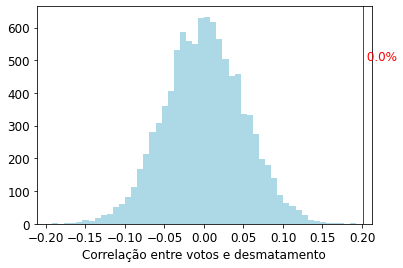

In [10]:
desmatamento_votos = compare_deflorestation_voting_data(df, votos, 'JAIR BOLSONARO', km2_min=800)
random_corrs, actual_corr, pvalue = corr_stats(desmatamento_votos)

pl.hist(random_corrs, bins=50, color='lightblue')
pl.axvline(actual_corr, color='r', linewidth=1)
pl.text(actual_corr, 500, ' {:.1f}%'.format(pvalue * 100), color='r', fontsize=12)
pl.tick_params(labelsize=12)
pl.xlabel('Correlação entre votos e desmatamento', fontsize=12)
pl.show()

In [11]:
from sklearn.linear_model import LinearRegression

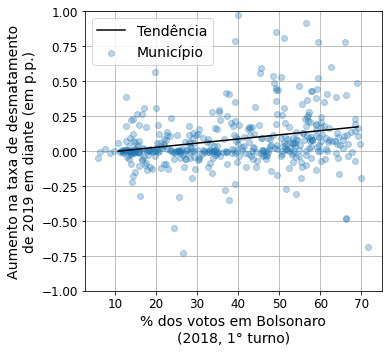

In [12]:
# Fit linear model:
lin_reg = LinearRegression()
dump = lin_reg.fit(desmatamento_votos[['frac_votos_totais']], desmatamento_votos['frac_desmatavel_diff'])
x_min = desmatamento_votos['frac_votos_totais'].sort_values().iloc[5]
x_max = desmatamento_votos['frac_votos_totais'].sort_values().iloc[-5]
x_lin = np.linspace(x_min, x_max, 5)
y_lin = lin_reg.predict(x_lin.reshape((-1, 1)))

# Scatter plot:
pl.figure(figsize=(5.5, 5))
pl.scatter(desmatamento_votos['frac_votos_totais'] * 100, desmatamento_votos['frac_desmatavel_diff'] * 100, alpha=0.3, label='Município')
pl.plot(x_lin * 100, y_lin * 100, color='k', label='Tendência')
pl.ylim([-1, 1])
#pl.xlim([0,15])
pl.xlabel('% dos votos em Bolsonaro\n(2018, 1° turno)', fontsize=14)
pl.ylabel('Aumento na taxa de desmatamento\nde 2019 em diante (em p.p.)', fontsize=14)
pl.tick_params(labelsize=12)
pl.gca().set_axisbelow(True)
pl.legend(fontsize=14)
pl.grid()
pl.tight_layout()
#pl.savefig('../resultados/plots/relacao_votos_bolsonaro_aumento_desmatamento.png')
pl.show()

### Evolução do agregado nacional e estadual

In [19]:
agg_Brasil = df.groupby('Ano')[areas_col].sum()
agg_ufs = df.groupby(['Estado', 'Ano'])[areas_col].sum()
agg_municipios = df.groupby(['CodIbge', 'Ano'])[areas_col].sum()
agg_municipios['frac_desmatavel'] = (agg_municipios['Incremento'] / agg_municipios['Desmatavel']).fillna(0)

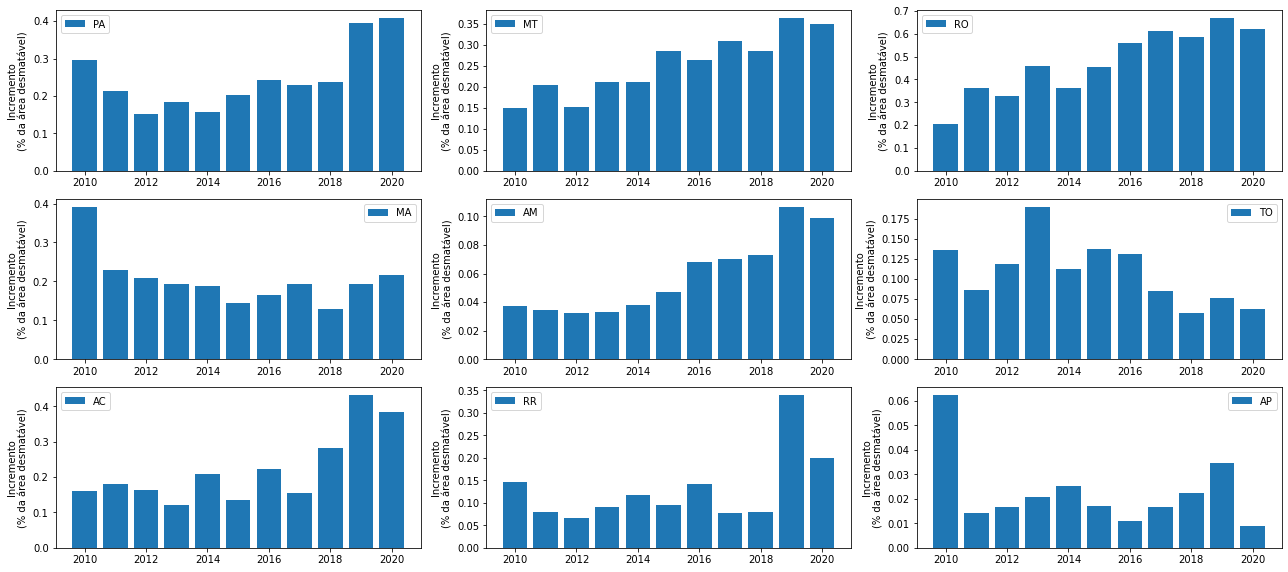

In [20]:
ufs = df['Estado'].unique()

pl.figure(figsize=(18, 8))
for i, uf in enumerate(ufs):
    pl.subplot(3,3, i + 1)
    df_uf = agg_ufs.loc[agg_ufs.index.get_level_values(0) == uf]
    pl.bar(df_uf.index.get_level_values(1), df_uf['Incremento'] / df_uf['Desmatavel'] * 100, label=uf)
    pl.ylabel('Incremento\n(% da área desmatável)')
    pl.legend()

pl.tight_layout()
pl.show()


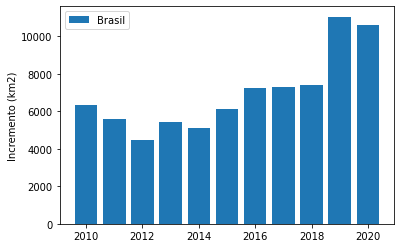

In [21]:
pl.bar(agg_Brasil.index, agg_Brasil['Incremento'], label='Brasil')
pl.legend()
pl.ylabel('Incremento (km2)')
pl.show()

### Relação entre áreas e o incremento

**Conclusão:** O incremento (em $\mathrm{km^2}$) do desmatamento é correlacionado com as áreas totais, o que condiz com a hipótese de uma probabilidade de desmatamento por área constante, e com a noção de que as delimitações políticas dos municípios não afetam o desmatamento. Portanto, o ideal é analisar o desmatamento por área, sendo que a área que parece mais adequada é a que denominamos `Desmatavel`, composta por `AreaKm2` - `Hidrografia` - `NaoFloresta`.

In [22]:
def one_plus_log(x):
    return np.log10(1 + x)

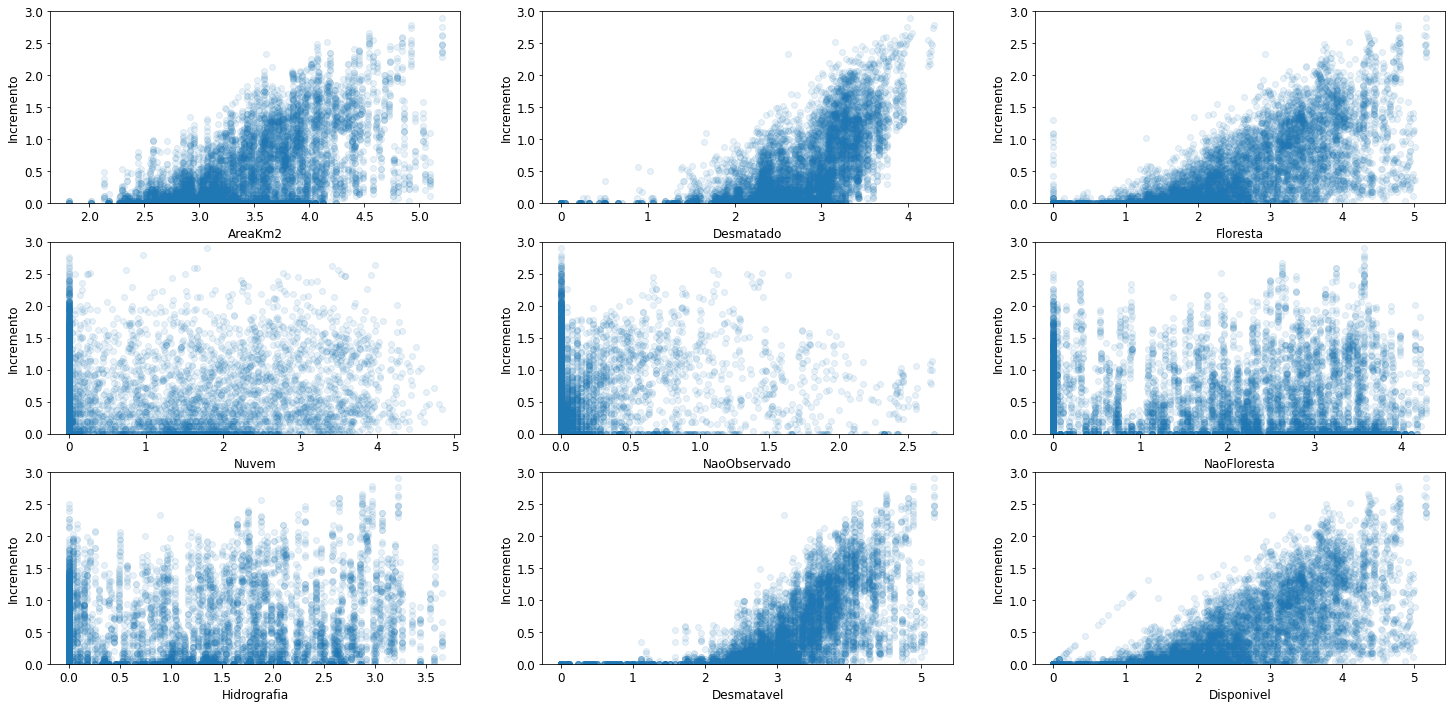

In [23]:
x = np.logspace(0,5,2)
pl.figure(figsize=(25,12))
for i in range(len(areas_col[1:])):
    pl.subplot(3, 3, i + 1)
    col = areas_col[1:][i]
    pl.scatter(one_plus_log(df[col]), one_plus_log(df['Incremento']), alpha=0.1)
    pl.xlabel(col, fontsize=12)
    pl.tick_params(labelsize=12)
    pl.ylim([0,3])
    pl.ylabel('Incremento', fontsize=12)
pl.show()

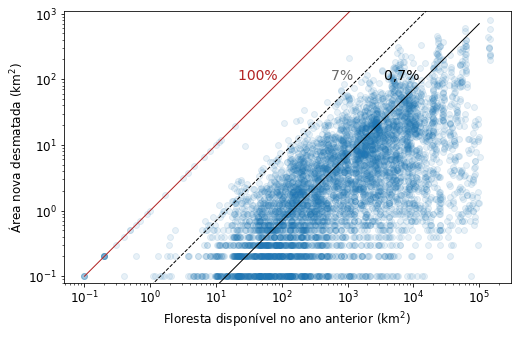

In [24]:
happened = df.loc[(df['Disponivel'] > 0) & (df['Incremento'] > 0)]

x = np.logspace(-1, 5, 5)
pl.figure(figsize=(8,5))
pl.scatter(happened['Disponivel'], happened['Incremento'], alpha=0.1)
pl.plot(x, x, color='firebrick', linewidth=1)
pl.text(100, 100, '100% ', fontsize=14, color='firebrick', ha='right')
pl.plot(x, x * 0.07, color='k', linewidth=1, linestyle='--')
pl.text(100/0.07, 100, '7% ', fontsize=14, color='dimgrey', ha='right')
pl.plot(x, x * 0.007, color='k', linewidth=1)
pl.text(100/0.007, 100, '0,7% ', fontsize=14, color='k', ha='right')
pl.xlabel('Floresta disponível no ano anterior ($\mathrm{km}^2$)', fontsize=12)
pl.tick_params(labelsize=12)
pl.yscale('log')
pl.xscale('log')
pl.ylim([0.08, 1100])
pl.ylabel('Área nova desmatada ($\mathrm{km}^2$)', fontsize=12)
pl.show()

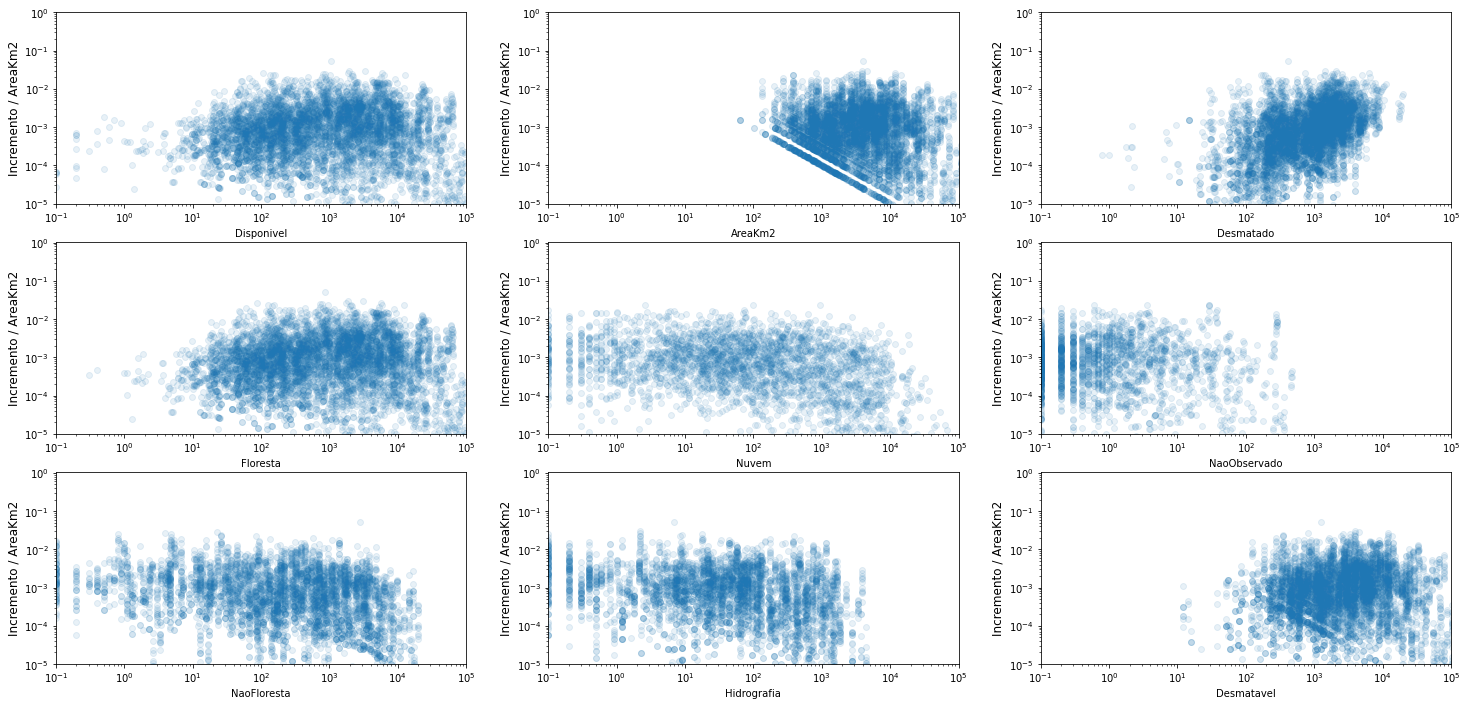

In [25]:
x = np.logspace(0,5,2)
pl.figure(figsize=(25,12))
for i in range(len(areas_col[1:])):
    f_col = 'AreaKm2'
    x_col = col
    pl.subplot(3, 3, i + 1)
    col = areas_col[1:][i]
    pl.scatter(df[x_col], df['Incremento'] / df[f_col], alpha=0.1)
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([1e-5, 1.05])
    pl.xlim([0.1, 1e5])
    pl.ylabel('Incremento / {}'.format(f_col), fontsize=12)
    pl.xlabel(x_col)
pl.show()

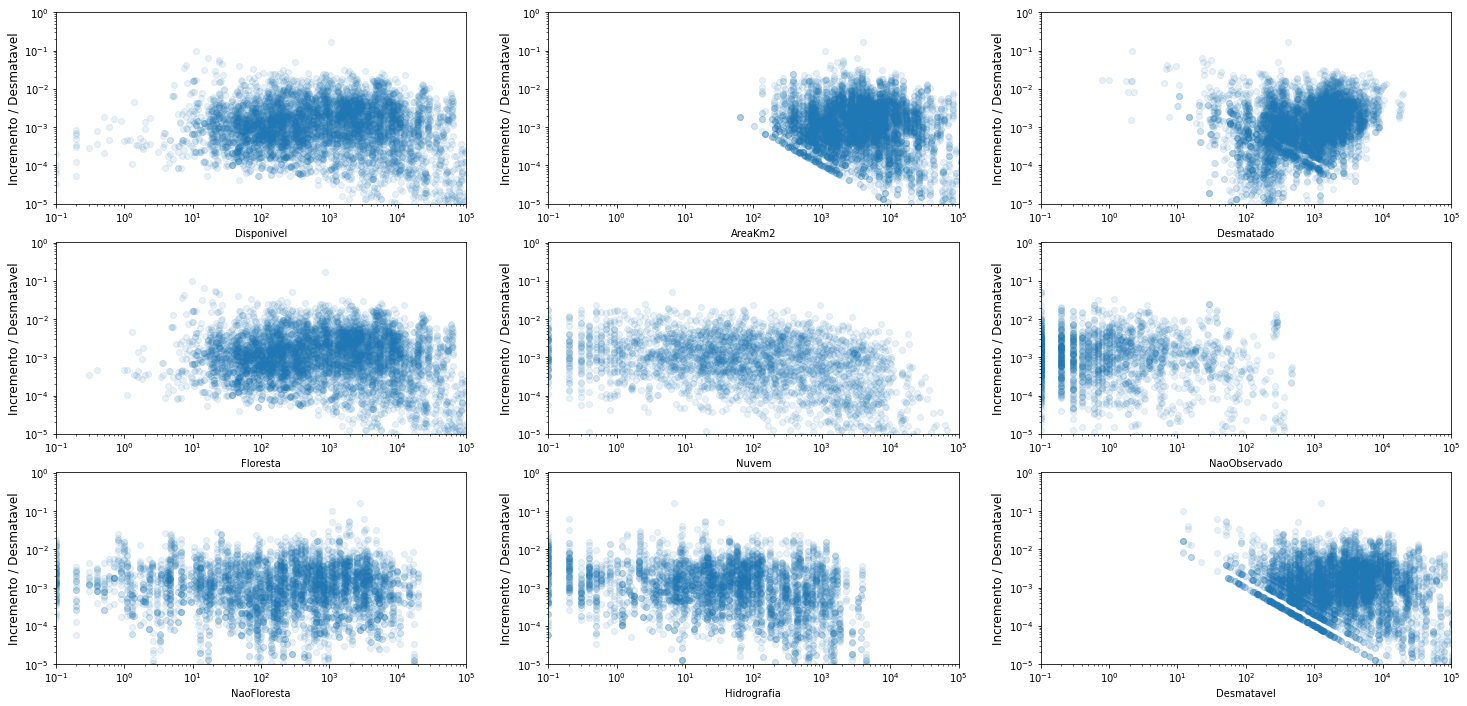

In [26]:
x = np.logspace(0,5,2)
pl.figure(figsize=(25,12))
for i in range(len(areas_col[1:])):
    f_col = 'Desmatavel'
    x_col = col
    pl.subplot(3, 3, i + 1)
    col = areas_col[1:][i]
    pl.scatter(df[x_col], df['Incremento'] / df[f_col], alpha=0.1)
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([1e-5, 1.05])
    pl.xlim([0.1, 1e5])
    pl.ylabel('Incremento / {}'.format(f_col), fontsize=12)
    pl.xlabel(x_col)
pl.show()

## Testes de sanidade

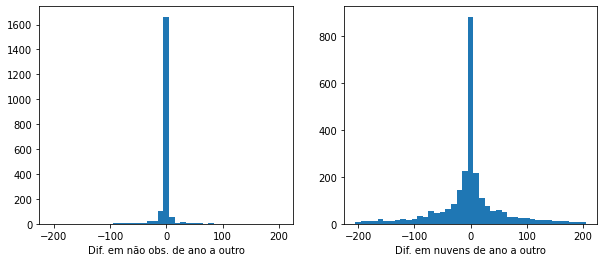

In [27]:
# Não observação e nuvens se distribuem sem tendência:
edges = np.arange(-205, 210, 10)
pl.figure(figsize=(10,4))
pl.subplot(1,2,1)
year_diff = xu.compute_differences_for_fixed_id(df, 'CodIbge', 'Ano', 'NaoObservado').dropna()
pl.hist(year_diff.loc[~np.isclose(year_diff, 0)], bins=edges)
pl.xlabel('Dif. em não obs. de ano a outro')
pl.subplot(1,2,2)
year_diff = xu.compute_differences_for_fixed_id(df, 'CodIbge', 'Ano', 'Nuvem').dropna()
pl.hist(year_diff.loc[~np.isclose(year_diff, 0)], bins=edges)
pl.xlabel('Dif. em nuvens de ano a outro')
pl.show()

In [28]:
# Significado da coluna Soma:
assert ((compute_measured_area_frac(df).astype(int) - df['Soma']).value_counts().abs().index <= 1).all()

In [29]:
# Incremento de y + 1 é a diferença entre desmatado de y + 1 e y:
for curr_year in [2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019, 2020]:
    print(curr_year, end=' ')
    df_curr = df.loc[df['Ano'] == curr_year].set_index('CodIbge')
    df_prev = df.loc[df['Ano'] == curr_year - 1].set_index('CodIbge')
    assert ((df_curr['Incremento'] - (df_curr['Desmatado'] - df_prev['Desmatado'])).abs() <= 0.10000001).all()

2011 2012 2013 2015 2016 2017 2018 2019 2020 

In [30]:
# Áreas que são constantes ao longo do tempo, para cada município:
for col in ['AreaKm2', 'NaoFloresta', 'Hidrografia']:
    print(col, end=' ')
    assert df.pivot(index='CodIbge', columns='Ano', values=col).eq(df.loc[df['Ano'] == 2020].set_index('CodIbge')[col].sort_index(), axis=0).all().all()

AreaKm2 NaoFloresta Hidrografia 